# Comparison of GP Classification Methods with Logistic Regression Cont.

Here, we will continue the work from the previous notebook. For detailed notes, about simulations, as well data in general, refer to previous notebook.

In [3]:
%pylab inline
import time
import GPy
import numpy as np
import matplotlib;matplotlib.rcParams['figure.figsize']=(10,6)
from matplotlib import pyplot as plt
from scipy import optimize

Populating the interactive namespace from numpy and matplotlib


# Simulation 5

In this part, we will look at increasing the number of input points, but keeping everything the same. For time-reasons, we will only look at classification rates and simple computation time, as well as the latent function approximations of course. We will avoid changing the no. of inducing points, the time-performance graph for now (this will be considered later).

More specifically, we are going to consider the same latent function as before. We will instead increase the no. of data points to 1500.

## Setting Up Simulation Data

Here, we will set up our simulated data. 

The data is set up in the exact same way as in simulation 1, but with $X$ now containing 1500 draws rather 100, and 150 inducing points rather than 10 (still 10% as before).

In [8]:
np.random.seed(101)             #to make it reproducible

X = np.random.rand(1500,1)*12    #draws from uniform distribution on [0,1) scaled by 12; data
f = np.cos(X/3)*3.8             #Appling f to X
p =np.exp(f)/(1+np.exp(f))      #Applying sigmoid function to f to return probabilities
Y = np.where(p>np.random.rand(*p.shape), 1,0)    #assign random classes
M=150
Z=np.random.rand(M,1)*12        #10 draws fron uniform distribution scaled by 12, inducing points

In [5]:
print(f"X: {X.shape}, f:{f.shape}, p: {p.shape}\nY:{Y.shape}, Z:{Z.shape}")

X: (1500, 1), f:(1500, 1), p: (1500, 1)
Y:(1500, 1), Z:(150, 1)


In [9]:
#Ordering variables

order = np.argsort(X[:,0])
X_ordered = X[order]
f_ordered = f[order]
p_ordered = p[order]

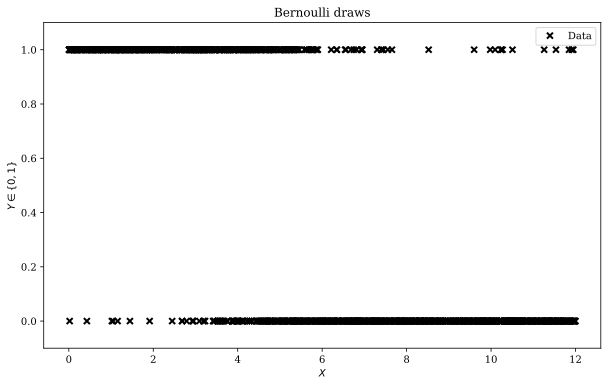

In [9]:
#Plot of data

plt.plot(X, Y, 'kx', mew=2)
plt.ylim(-0.1, 1.1)
plt.title('Bernoulli draws')
plt.xlabel('$X$')
plt.ylabel('$Y \in \{0,1\}$')
plt.legend( ["Data"], loc="best")

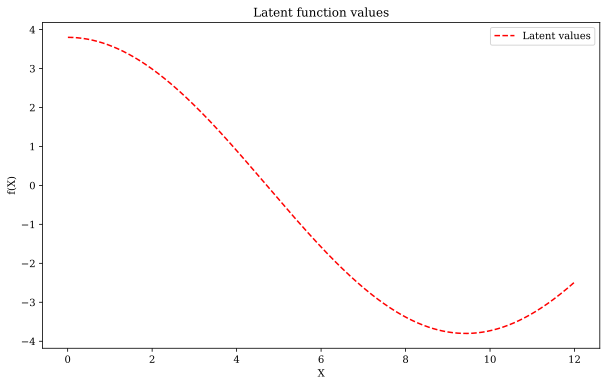

In [10]:
#Plotting latent function values

plt.plot(X_ordered, f_ordered, color="red", ls="--")
plt.title('Latent function values')
plt.xlabel('X')
plt.ylabel('f(X)')
plt.legend( ['Latent values'], loc="best")
#plt.plot(X, p, 'r.')

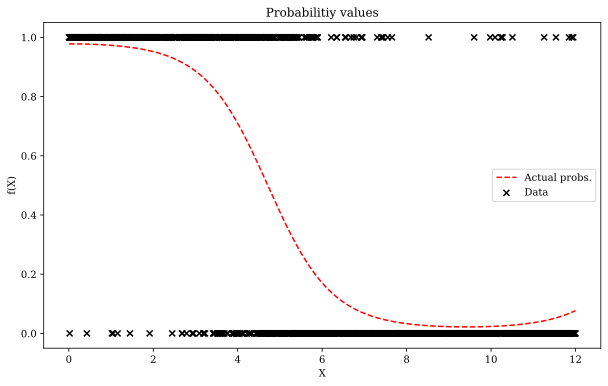

In [11]:
#Plotting actual probabilities

plt.plot(X_ordered, p_ordered, color="red", ls="--")
plt.scatter(X,Y, color="black", marker="x")
plt.title('Probabilitiy values')
plt.xlabel('X')
plt.ylabel('f(X)')
plt.legend( ['Actual probs.', "Data"], loc="best")
#plt.plot(X, p, 'r.')

## GP Variational Classification

In [12]:
#Stochastic Variational GP model, with sparse approximations 


m = GPy.core.SVGP(X, Y, kernel=GPy.kern.RBF(1)+GPy.kern.White(1), likelihood=GPy.likelihoods.Bernoulli(), Z=Z)

Text(0.5, 1.0, 'Prediction of latent probabilities - sparse model, optimized')

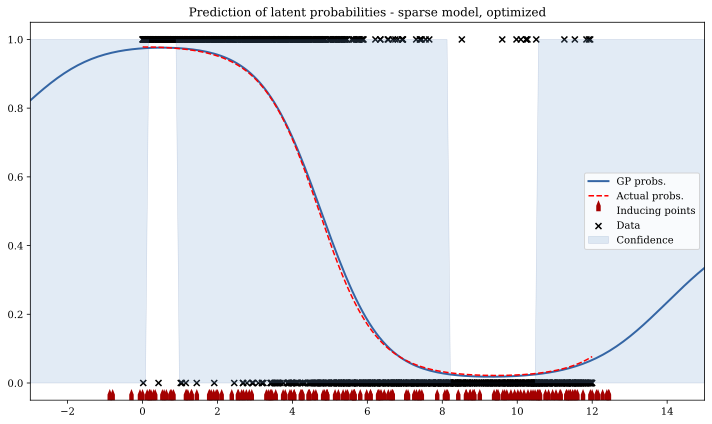

In [13]:
#Optimizing model and plotting model probabilities

t0 = time.time()
m.optimize('bfgs')
t1 = time.time()

m.plot()   #model plot of probabilities
plt.plot(X_ordered, p_ordered, color="red", ls="--")   #actual plot of probabilities
plt.legend( ['GP probs.', 'Actual probs.', "Inducing points", "Data", "Confidence"])
plt.title("Prediction of latent probabilities - sparse model, optimized")
#plt.plot(X, p, 'r.')

In [14]:
#Time taken

print(f'Time taken for sparse variational model: {t1-t0}')

Time taken for sparse variational model: 68.78392362594604


In [15]:
#Model output 

dir(m) #model attributes
m

In [16]:
#Full model, without sparse approximations

m_full = GPy.models.GPVariationalGaussianApproximation(X, Y, kernel=GPy.kern.RBF(1)+GPy.kern.White(1), likelihood=GPy.likelihoods.Bernoulli())

Text(0.5, 1.0, 'Prediction of latent probabilities - full model, optimized')

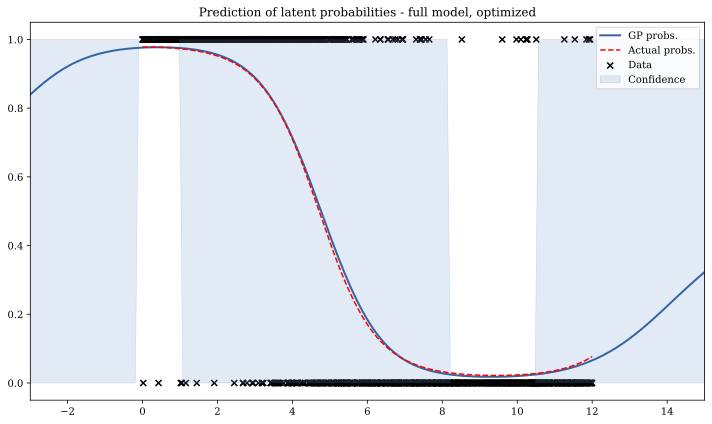

In [17]:
#Optimizing model and plotting model probabilities

t0 = time.time()
m_full.optimize()
t1 = time.time()

m_full.plot()   #full model plot of probabilities 
plt.plot(X_ordered, p_ordered, color="red", ls="--")  #actual plot of probabilities
plt.legend( ['GP probs.', 'Actual probs.', "Data", "Confidence"])
plt.title("Prediction of latent probabilities - full model, optimized")

#plt.plot(X, p, 'r.')

In [18]:
#Time taken

print(f'Time taken for full variational model: {t1-t0}')

Time taken for full variational model: 226.503972530365


In [20]:
#Model output

dir(m_full)  #model attributes
m_full

## GP Laplacian Classification

In [2]:
#PLotting specifications

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
#import matplotlib;matplotlib.rcParams['text.usetex'] = True
import matplotlib;matplotlib.rcParams['font.size'] = 16
import matplotlib;matplotlib.rcParams['font.family'] = 'serif'

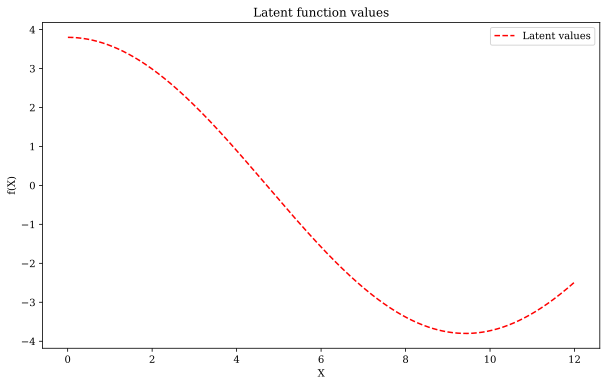

In [21]:
#Plotting latent function values again

plt.plot(X_ordered, f_ordered, color="red", ls="--")
plt.title('Latent function values')
plt.xlabel('X')
plt.ylabel('f(X)')
plt.legend( ['Latent values'], loc="best")
#plt.plot(X, p, 'r.')

In [10]:
#Obtaining probabilities for Laplacian method - uses probit link instead of logit

lik = GPy.likelihoods.Bernoulli()    #Bernoulli likelihood
p = lik.gp_link.transf(f)            #Link function giving probabilities associated with f - applies probit transformation
p_ordered = p[order]
p.shape

(1500, 1)

Text(0, 0.5, '$\\sigma(f(x))$')

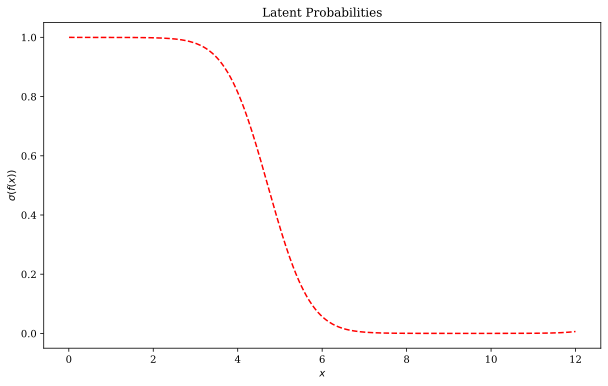

In [7]:
#Plot of latent probabilities obtained from f

plt.plot(X_ordered, p_ordered, color="red", ls="--")
plt.title('Latent Probabilities')
plt.xlabel('$x$')
plt.ylabel('$\sigma(f(x))$')

In [11]:
#Creating Laplacian inference model

t0 = time.time()
kl = GPy.kern.RBF(1, variance=1., lengthscale=1)        #Kernel with specific legnthscale and variance, both set to units
laplace_inf = GPy.inference.latent_function_inference.Laplace()
m_laplace = GPy.core.GP(X=X,
                Y=Y, 
                kernel=kl, 
                inference_method=laplace_inf,
                likelihood=lik)
t1 = time.time()

In [31]:
#Time taken

print(f'Time taken for unoptimized Laplacian model: {t1-t0}')

Time taken for unoptimized Laplacian model: 3.608421802520752


In [32]:
#Output of unoptimized model

print(m_laplace)


Name : gp
Objective : 439.0084057167533
Number of Parameters : 2
Number of Optimization Parameters : 2
Updates : True
Parameters:
  gp.              |  value  |  constraints  |  priors
  rbf.variance     |    1.0  |      +ve      |        
  rbf.lengthscale  |    1.0  |      +ve      |        


Text(0.5, 1.0, 'Prediction of latent values - unoptimized')

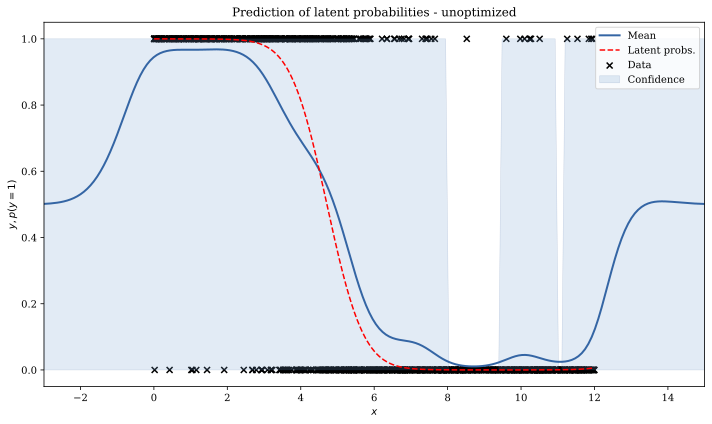

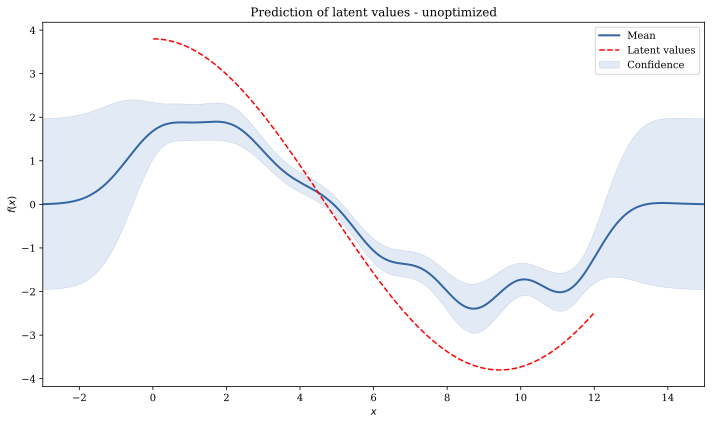

In [12]:
#Plot Laplacian inference model, unoptimized

#Plot of latent probabilities, with predictions of mean and confidence intervals

m_laplace.plot()
plt.plot(X_ordered, p_ordered, color="red", ls="--")
plt.ylabel('$y, p(y=1)$')
plt.xlabel('$x$')
plt.legend( ["Mean", "Latent probs.", "Data", "Confidence"], loc="best")
plt.title("Prediction of latent probabilities - unoptimized")

m_laplace.plot_f()
plt.plot(X_ordered, f_ordered, color="red", ls="--")
plt.ylabel('$f(x)$')
plt.xlabel('$x$')
plt.legend( ["Mean", "Latent values", "Confidence"], loc="best")
plt.title("Prediction of latent values - unoptimized")

In [13]:
#Optimizing 

t0= time.time()
m_laplace.optimize('bfgs', max_iters=100)
t1 = time.time()
print(m_laplace)


Name : gp
Objective : 429.9217312805821
Number of Parameters : 2
Number of Optimization Parameters : 2
Updates : True
Parameters:
  gp.              |               value  |  constraints  |  priors
  rbf.variance     |  2.8396658232874756  |      +ve      |        
  rbf.lengthscale  |   4.623471602757171  |      +ve      |        


In [35]:
#Time taken

print(f'Time taken for Laplacian model: {t1-t0}')

Time taken for Laplacian model: 43.54361009597778


Text(0.5, 1.0, 'Prediction of latent values - optimized')

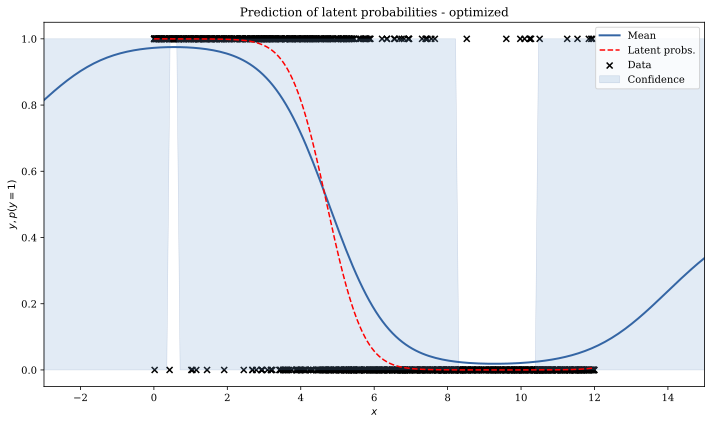

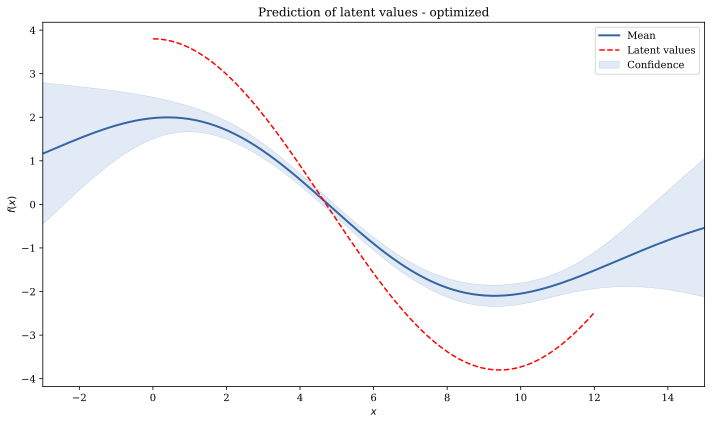

In [14]:
#Plot Laplacian inference model, optimized

#Plot of latent probabilities, with predictions of mean and confidence intervals


m_laplace.plot()
plt.plot(X_ordered, p_ordered, color="red", ls="--")
plt.ylabel('$y, p(y=1)$')
plt.xlabel('$x$')
plt.legend( ["Mean", "Latent probs.", "Data", "Confidence"], loc="best")
plt.title("Prediction of latent probabilities - optimized")

m_laplace.plot_f()
plt.plot(X_ordered, f_ordered, color="red", ls="--")
plt.ylabel('$f(x)$')
plt.xlabel('$x$')
plt.legend( ["Mean", "Latent values", "Confidence"], loc="best")
plt.title("Prediction of latent values - optimized")

## Logistic Regression for Classification

In [15]:
#Importing necessary modules

import pandas as pd
from statsmodels.tools import add_constant
import statsmodels.api as sm
from scipy.special import expit, logit

In [16]:
#Fitting logistic regression model with logit link, including intercept term

X_design = add_constant(X)
t0 = time.time()
model = sm.Logit(Y, X_design).fit()
t1 = time.time()

Optimization terminated successfully.
         Current function value: 0.294955
         Iterations 8


In [39]:
#Time taken

print(f'Time taken for logistic regression model: {t1-t0}')

Time taken for logistic regression model: 0.007998943328857422


In [40]:
#Model summary

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 1500
Model:                          Logit   Df Residuals:                     1498
Method:                           MLE   Df Model:                            1
Date:                Sun, 13 Dec 2020   Pseudo R-squ.:                  0.5607
Time:                        23:32:46   Log-Likelihood:                -442.43
converged:                       True   LL-Null:                       -1007.0
Covariance Type:            nonrobust   LLR p-value:                1.485e-247
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.4818      0.250     17.916      0.000       3.991       4.972
x1            -0.9303      0.048    -19.348      0.000      -1.025      -0.836
==============================================================================
"""

In [17]:
#Making predictions of latent probabilities

predictions = model.predict(X_design).reshape(1500,1)
predictions.shape

(1500, 1)

In [18]:
#Finding 95% confidence intervals for predicted probabilities

se= np.sqrt(np.array([xx@model.cov_params()@xx for xx in X_design]))   #standards errors of predictions
se = se.reshape(1500,1)                                                 #reshaping se
conf_lower_prob = expit(logit(predictions) - 1.96*se)
conf_upper_prob = expit(logit(predictions) + 1.96*se)

Text(0.5, 1.0, 'Prediction of latent probabilities - optimized')

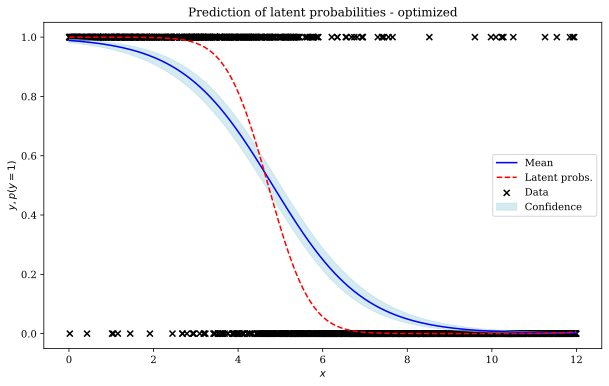

In [19]:
#Plotting mean of predictions with 95% confidence interval

#Ordering for plotting

ordered_pred = predictions[order]                      #ordering probability predictions
ordered_conf_lower_prob = conf_lower_prob[order]               #Order confidence intervals for plotting
ordered_conf_upper_prob = conf_upper_prob[order]     

plt.plot(X_ordered, ordered_pred, color="blue")
plt.scatter(X, Y, marker="x", color="black")
plt.plot(X_ordered, p_ordered, color="red", ls="--")
plt.fill_between(X_ordered.reshape(1500), ordered_pred.reshape(1500), 
                 ordered_conf_upper_prob.reshape(1500), color='lightblue', alpha=.5)
plt.fill_between(X_ordered.reshape(1500), ordered_conf_lower_prob.reshape(1500), 
                 ordered_pred.reshape(1500), color='lightblue', alpha=.5)
plt.ylabel('$y, p(y=1)$')
plt.xlabel('$x$')
plt.legend( ["Mean", "Latent probs.", "Data", "Confidence"], loc="best")
plt.title("Prediction of latent probabilities - optimized")


#Upper confidence bound and lower confidence bound

#plt.plot(X_ordered, ordered_conf_lower_prob, color="violet")
#plt.plot(X_ordered, ordered_conf_upper_prob, color="violet")

Text(0.5, 1.0, 'Prediction of latent values - optimized')

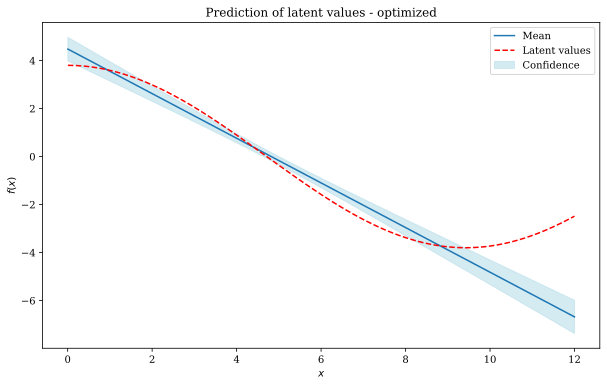

In [20]:
#Prediction of latent values

ordered_values_pred = logit(ordered_pred)   #ordered value predictions obtained by  applying logit to probability predictions

plt.plot(X_ordered, ordered_values_pred)
plt.plot(X_ordered, f_ordered, color="red", ls="--")
plt.fill_between(X_ordered.reshape(1500), ordered_values_pred.reshape(1500), 
                 logit(ordered_conf_upper_prob).reshape(1500), color='lightblue', alpha=.5)
plt.fill_between(X_ordered.reshape(1500), logit(ordered_conf_lower_prob).reshape(1500), 
                 ordered_values_pred.reshape(1500), color='lightblue', alpha=.5)
plt.ylabel('$f(x)$')
plt.xlabel('$x$')
plt.legend( ["Mean", "Latent values", "Confidence"], loc="best")
plt.title("Prediction of latent values - optimized")

## Comparing Classification Methods

Here we will compare the classification methods based on their fit to the training data. For the future we may consider subsetting our data into a train-validation-test split.

In [48]:
#Prediction from sparse variational model
#Classification bsaed on threshold of 0.5

predict_sparse_var = m.predict(X)[0]
classification_sparse_var = np.where(predict_sparse_var >= 0.5, 1, 0)
CRR_sparse_var = np.where(classification_sparse_var == Y)[0].size/Y.size    #corect classification rate

In [49]:
#Prediction from full variational model
#Classification bsaed on threshold of 0.5

predict_full_var = m_full.predict(X)[0]
classification_full_var = np.where(predict_full_var >= 0.5, 1, 0)
CRR_full_var = np.where(classification_full_var == Y)[0].size/Y.size    #corect classification rate

In [50]:
CRR_full_var, CRR_sparse_var

(0.8873333333333333, 0.888)

In [51]:
#Prediction from laplacian model
#Classification bsaed on threshold of 0.5

predict_laplace = m_laplace.predict(X)[0]
classification_laplace = np.where(predict_laplace >= 0.5, 1, 0)
CRR_laplace = np.where(classification_laplace == Y)[0].size/Y.size    #corect classification rate

In [52]:
CRR_laplace

0.8873333333333333

In [53]:
#Prediction from logistic regression model
#Classification bsaed on threshold of 0.5

classification_logistic = np.where(predictions >= 0.5, 1, 0)
CRR_logistic = np.where(classification_logistic == Y)[0].size/Y.size    #corect classification rate

In [54]:
CRR_logistic

0.8866666666666667

## Summary:

Here, we see that all the models produced the same classification rate (to 2 d.p.). However, by inspection of the latent probability and function value plots, it is clear the there are differences between the models. In particular, we see that the sparse an full variational method provide the best fit to the latent probabilitiies and function values. Following from this, the logistic regression model provides the the second best fit and the  Laplacian models provides the third best fit.

For further comparison, it may be useful to plot ROC curves and calculate AUCs for the respective models. This can either be directly coded or done via open-source packages such as scikit-learn.

Computation wise, logistic regression performed the quickest, followed by the Laplacian method, then sparse variational GP and lastly the full GP. Reasons for this will be considered.


<ins>**N.B.**</ins>: The sparse variational model performed around at the same level as the full varational model, with a reduction in computation time.


# Simulation 6

In this part, we will look increasing the dimensions of our data to 3D. For simplicity and time-reasons, we will use the data with just 100 input points. The idea here is to demonstrate that GP models' computation efficiency in independent of dimensions size, though dependent on number of training inputs.

Our 3D function is a product of two cosines for simplicity, everything else is kept the same.

## Setting Up Simulation Data

Here, we will set up our simulated data. 

The data is set up in the exact same way as in simulation 1, but with $X$ now containing 1500 draws rather 100, and 150 inducing points rather than 10 (still 10% as before). We have a 3D latent function in this case also.

In [12]:
np.random.seed(101)             #to make it reproducible

x1 = np.random.rand(1500,1)*12    #draws from uniform distribution on [0,1) scaled by 12; data
x2 = np.random.rand(1500,1)*12    #draws from uniform distribution on [0,1) scaled by 12; data
X = np.column_stack((x1,x2))
f =  np.cos((x1+x2)/3)*3.8        #Appling f to X
p =np.exp(f)/(1+np.exp(f))      #Applying sigmoid function to f to return probabilities
Y = np.where(p>np.random.rand(*p.shape), 1,0)    #assign random classes
M=300
Z=(np.random.rand(M,1)*12).reshape(150,2)        #10 draws fron uniform distribution for x1, x2, scaled by 12, inducing points

In [13]:
order = np.argsort(x1[:,0])

x1_ordered = x1[order]
x2_ordered = x2[order]
f_ordered = f[order]
p_ordered = p[order]

In [14]:
print(f"X: {X.shape}, f:{f.shape}, p: {p.shape}\nY:{Y.shape}, Z:{Z.shape}")

X: (1500, 2), f:(1500, 1), p: (1500, 1)
Y:(1500, 1), Z:(150, 2)


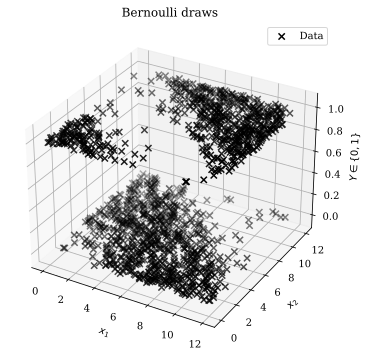

In [15]:
#Plot of data

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(x1, x2, Y, marker="x", color="black", s=40)
ax.set_zlim3d(-0.1, 1.1)
ax.set_title('Bernoulli draws')
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_zlabel('$Y \in \{0,1\}$')
ax.legend( ["Data"], loc="best")
plt.show()

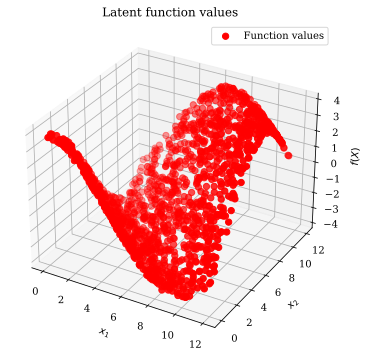

In [16]:
#Plotting latent function values

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(x1, x2, f, color="r", marker="o", s=40)
ax.set_title("Latent function values")
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_zlabel('$f(X)$')
ax.legend( ["Function values"], loc="best")
plt.show()

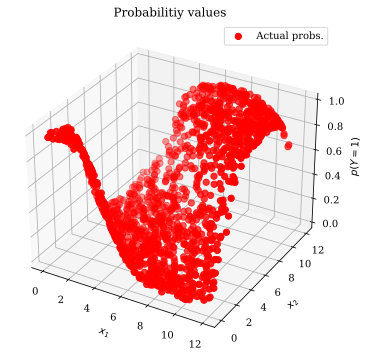

In [17]:
#Plotting actual probabilities


fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(x1, x2, p, color="r", marker="o", s=40)
ax.set_title("Probabilitiy values")
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_zlabel('$p(Y=1)$')
ax.legend(['Actual probs.', "Data"], loc="best")
plt.show()

## GP Variational Classification

In [18]:
X.shape, Y.shape, Z.shape

((1500, 2), (1500, 1), (150, 2))

In [19]:
#Stochastic Variational GP model, with sparse approximations 

m = GPy.core.SVGP(X, Y, kernel=GPy.kern.RBF(2)+GPy.kern.White(2), likelihood=GPy.likelihoods.Bernoulli(), Z=Z)

 c:\users\ashou\anaconda3\envs\gp_project\lib\site-packages\GPy\plotting\matplot_dep\plot_definitions.py:184: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


Text(0.5, 1.0, 'Prediction of latent probabilities - sparse model, optimized')

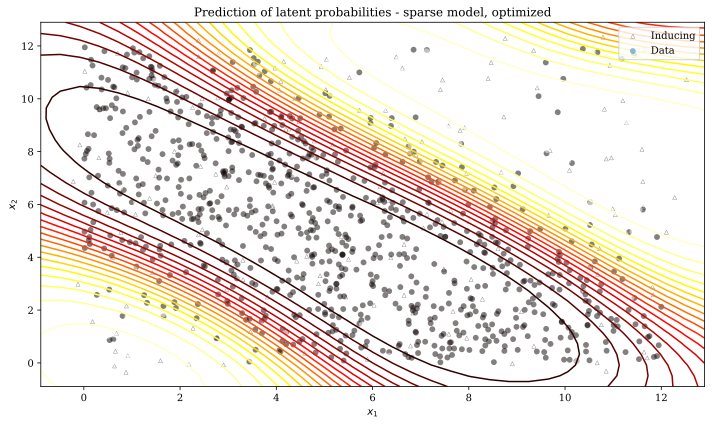

In [20]:
#Optimizing model and plotting model probabilities

t0 = time.time()
m.optimize('bfgs')
t1 = time.time()

m.plot()   #model plot of probabilities
plt.ylabel('$x_2$')
plt.xlabel('$x_1$')
#plt.plot(x1_ordered, x2_ordered color="red", ls="--")   #actual plot of probabilities
#plt.legend( ['GP probs.', 'Actual probs.', "Inducing points", "Data", "Confidence"])
plt.title("Prediction of latent probabilities - sparse model, optimized")
#plt.plot(X, p, 'r.')

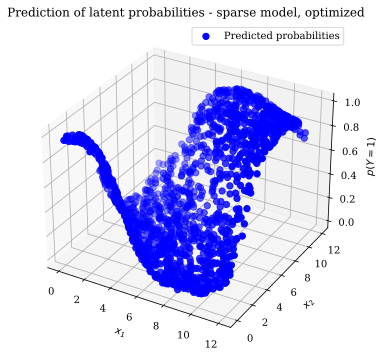

In [21]:
#3D plot of predicted probabilities

predict_sparse_var = m.predict(X)[0]

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(x1, x2, predict_sparse_var, color="b", marker="o", s=40)
#ax.scatter(x1, x2, f, color="r", marker="o", s=40)
ax.set_title("Prediction of latent probabilities - sparse model, optimized")
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_zlabel('$p(Y=1)$')
ax.legend( ["Predicted probabilities"], loc="best")
plt.show()

In [22]:
#Time taken

print(f'Time taken for sparse variational model: {t1-t0}')

Time taken for sparse variational model: 74.68614864349365


In [23]:
#Model output 

dir(m) #model attributes
m

In [24]:
#Full model, without sparse approximations
m_full = GPy.models.GPVariationalGaussianApproximation(X, Y, kernel=GPy.kern.RBF(2)+GPy.kern.White(2), likelihood=GPy.likelihoods.Bernoulli())

Text(0.5, 1.0, 'Prediction of latent probabilities - full model, optimized')

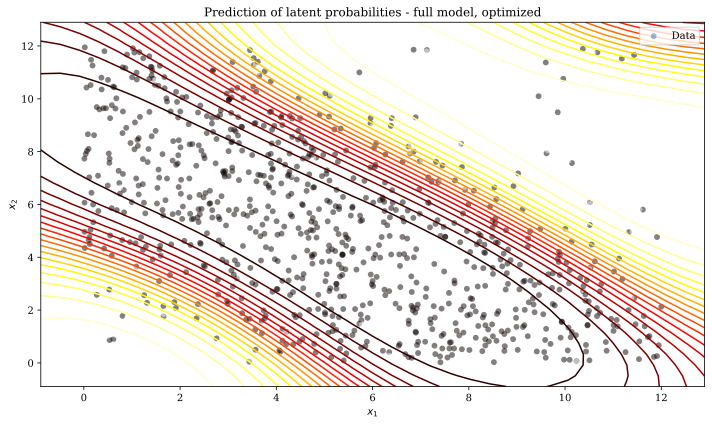

In [25]:
#Optimizing model and plotting model probabilities

t0 = time.time()
m_full.optimize()
t1 = time.time()

m_full.plot()   #full model plot of probabilities 
plt.ylabel('$x_2$')
plt.xlabel('$x_1$')
#plt.plot(x1_ordered, x2_ordered, color="red", ls="--")  #actual plot of probabilities
#plt.legend( ['GP probs.', 'Actual probs.', "Data", "Confidence"])
plt.title("Prediction of latent probabilities - full model, optimized")

#plt.plot(X, p, 'r.')

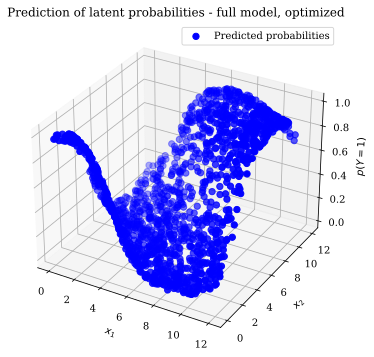

In [46]:
#3D plot of predicted probabilities

predict_full_var = m_full.predict(X)[0]

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(x1, x2, predict_full_var, color="b", marker="o", s=40)
#ax.scatter(x1, x2, f, color="r", marker="o", s=40)
ax.set_title("Prediction of latent probabilities - full model, optimized")
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_zlabel('$p(Y=1)$')
ax.legend( ["Predicted probabilities"], loc="best")
plt.show()

In [27]:
#Time taken

print(f'Time taken for full variational model: {t1-t0}')

Time taken for full variational model: 1112.6189885139465


In [28]:
#Model output

dir(m_full)  #model attributes
m_full

## GP Laplacian Classification

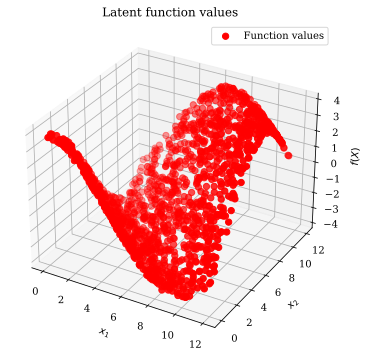

In [29]:
#Plotting latent function values again

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(x1, x2, f, color="r", marker="o", s=40)
ax.set_title("Latent function values")
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_zlabel('$f(X)$')
ax.legend( ["Function values"], loc="best")
plt.show()

In [30]:
#Obtaining probabilities for Laplacian method - uses probit link instead of logit

lik = GPy.likelihoods.Bernoulli()    #Bernoulli likelihood
p_lap = lik.gp_link.transf(f)            #Link function giving probabilities associated with f - applies probit transformation
p_lap_ordered = p_lap[order]
p.shape

(1500, 1)

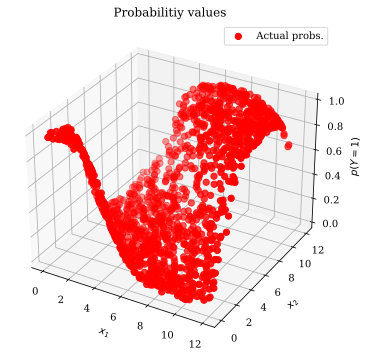

In [31]:
#Plot of latent probabilities obtained from f

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(x1, x2, p, color="r", marker="o", s=40)
ax.set_title("Probabilitiy values")
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_zlabel('$p(Y=1)$')
ax.legend(['Actual probs.', "Data"], loc="best")
plt.show()

In [33]:
#Creating Laplacian inference model

t0 = time.time()
kl = GPy.kern.RBF(2, variance=1., lengthscale=1)        #Kernel with specific legnthscale and variance, both set to units
laplace_inf = GPy.inference.latent_function_inference.Laplace()
m_laplace = GPy.core.GP(X=X,
                Y=Y, 
                kernel=kl, 
                inference_method=laplace_inf,
                likelihood=lik)
t1 = time.time()

In [34]:
#Time taken

print(f'Time taken for unoptimized Laplacian model: {t1-t0}')

Time taken for unoptimized Laplacian model: 4.957330703735352


In [35]:
#Output of unoptimized model

print(m_laplace)


Name : gp
Objective : 535.840167781681
Number of Parameters : 2
Number of Optimization Parameters : 2
Updates : True
Parameters:
  gp.              |  value  |  constraints  |  priors
  rbf.variance     |    1.0  |      +ve      |        
  rbf.lengthscale  |    1.0  |      +ve      |        


Text(0.5, 1.0, 'Prediction of latent values - unoptimized')

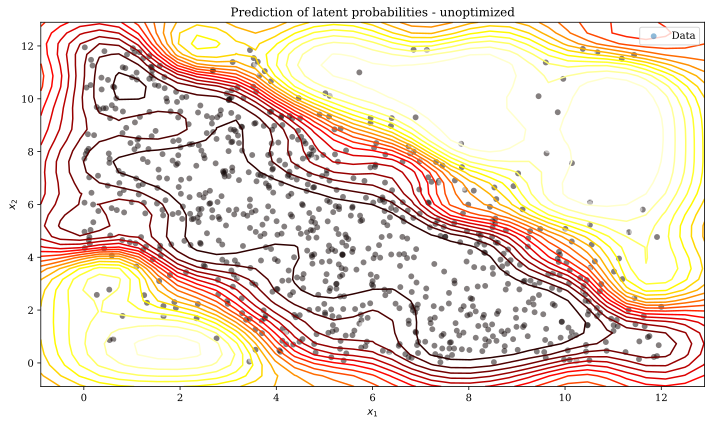

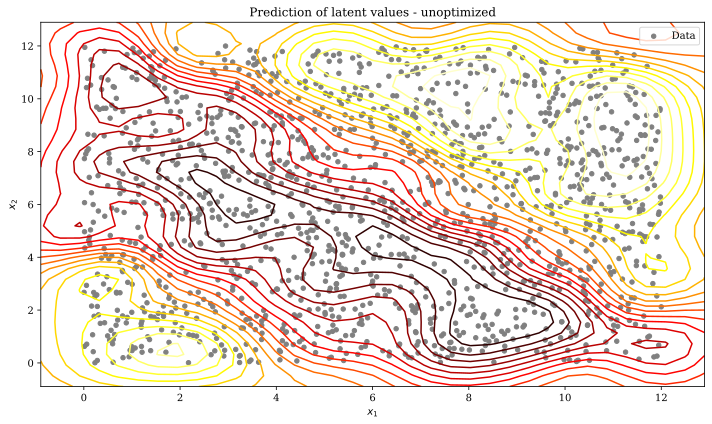

In [36]:
#Plot Laplacian inference model, unoptimized

#Plot of latent probabilities, with predictions of mean and confidence intervals

m_laplace.plot()
#plt.plot(X_ordered, p_lap_ordered, color="red", ls="--")
plt.ylabel('$x_2$')
plt.xlabel('$x_1$')
#plt.legend( ["Mean", "Latent probs.", "Data", "Confidence"], loc="best")
plt.title("Prediction of latent probabilities - unoptimized")

m_laplace.plot_f()
plt.scatter(x1, x2, color="grey", s=20)
plt.ylabel('$x_2$')
plt.xlabel('$x_1$')
plt.legend( ["Data"], loc="best")
plt.title("Prediction of latent values - unoptimized")

In [37]:
#Optimizing 

t0= time.time()
m_laplace.optimize('bfgs', max_iters=100)
t1 = time.time()
print(m_laplace)


Name : gp
Objective : 496.37891141457317
Number of Parameters : 2
Number of Optimization Parameters : 2
Updates : True
Parameters:
  gp.              |               value  |  constraints  |  priors
  rbf.variance     |  3.1982686241712606  |      +ve      |        
  rbf.lengthscale  |   4.225916375884072  |      +ve      |        


In [38]:
#Time taken

print(f'Time taken for Laplacian model: {t1-t0}')

Time taken for Laplacian model: 58.37046265602112


Text(0.5, 1.0, 'Prediction of latent values - optimized')

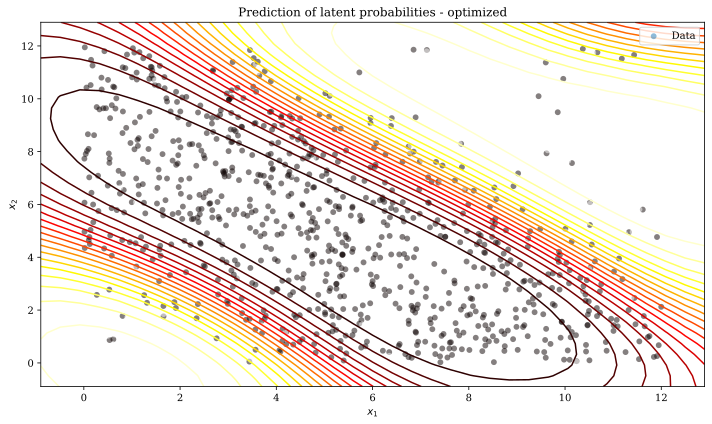

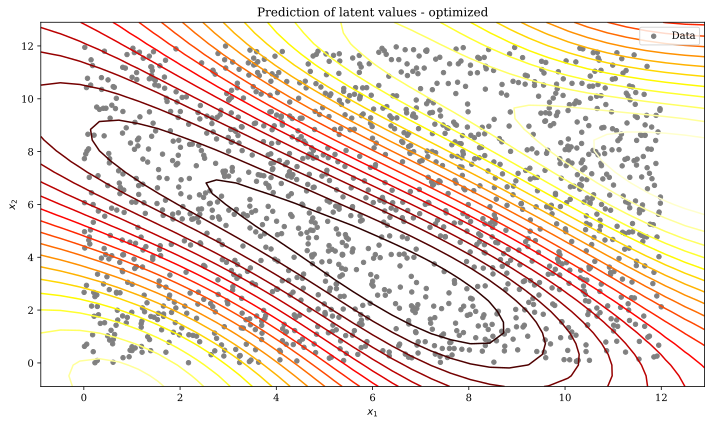

In [39]:
#Plot Laplacian inference model, optimized

#Plot of latent probabilities, with predictions of mean and confidence intervals


m_laplace.plot()
#plt.scatter(x1, x2, color="grey")
plt.ylabel('$x_2$')
plt.xlabel('$x_1$')
#plt.legend( ["Mean", "Latent probs.", "Data", "Confidence"], loc="best")
plt.title("Prediction of latent probabilities - optimized")

m_laplace.plot_f()
plt.scatter(x1, x2, color="grey", s=20)
plt.ylabel('$x_2$')
plt.xlabel('$x_1$')
plt.legend( ["Data"], loc="best")
plt.title("Prediction of latent values - optimized")

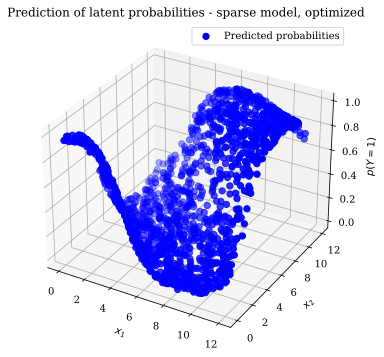

In [40]:
#3D plot of predicted probabilities

predict_laplace = m_laplace.predict(X)[0]

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(x1, x2, predict_laplace, color="b", marker="o", s=40)
#ax.scatter(x1, x2, f, color="r", marker="o", s=40)
ax.set_title("Prediction of latent probabilities - sparse model, optimized")
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_zlabel('$p(Y=1)$')
ax.legend( ["Predicted probabilities"], loc="best")
plt.show()

## Logistic Regression for Classification

In [42]:
#Fitting logistic regression model with logit link, including intercept term

X_design = add_constant(X)
t0 = time.time()
model = sm.Logit(Y, X_design).fit()
t1 = time.time()

Optimization terminated successfully.
         Current function value: 0.601418
         Iterations 5


In [43]:
#Time taken

print(f'Time taken for logistic regression model: {t1-t0}')

Time taken for logistic regression model: 0.01898956298828125


In [44]:
#Model summary

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 1500
Model:                          Logit   Df Residuals:                     1497
Method:                           MLE   Df Model:                            2
Date:                Thu, 17 Dec 2020   Pseudo R-squ.:                  0.1199
Time:                        10:33:36   Log-Likelihood:                -902.13
converged:                       True   LL-Null:                       -1025.0
Covariance Type:            nonrobust   LLR p-value:                 4.457e-54
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.5701      0.175    -14.720      0.000      -2.912      -2.228
x1             0.1847      0.017     10.646      0.000       0.151       0.219
x2             0.1877      0.017     10.807      0.000       0.154       0.222
==============================================================================
"""

In [47]:
#Making predictions of latent probabilities

predictions = model.predict(X_design).reshape(1500,1)
predictions.shape

(1500, 1)

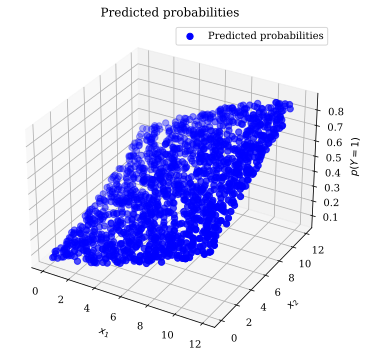

In [48]:
#Plotting mean of predictions without 95% confidence interval to spare difficulty of plotting

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(x1, x2, predictions, color="b", marker="o", s=40)
#ax.scatter(x1, x2, f, color="r", marker="o", s=40)
ax.set_title("Predicted probabilities")
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_zlabel('$p(Y=1)$')
ax.legend( ["Predicted probabilities"], loc="best")
plt.show()

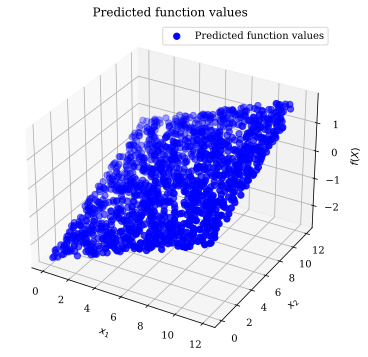

In [50]:
#Prediction of latent values

values_pred = logit(predictions)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(x1, x2, values_pred, color="b", marker="o", s=40)
#ax.scatter(x1, x2, f, color="r", marker="o", s=40)
ax.set_title("Predicted function values")
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_zlabel('$f(X)$')
ax.legend( ["Predicted function values"], loc="best")
plt.show()

## Comparing Classification Methods

Here we will compare the classification methods based on their fit to the training data. For the future we may consider subsetting our data into a train-validation-test split.

In [51]:
#Prediction from sparse variational model
#Classification bsaed on threshold of 0.5

classification_sparse_var = np.where(predict_sparse_var >= 0.5, 1, 0)
CRR_sparse_var = np.where(classification_sparse_var == Y)[0].size/Y.size    #corect classification rate

In [52]:
#Prediction from full variational model
#Classification bsaed on threshold of 0.5

classification_full_var = np.where(predict_full_var >= 0.5, 1, 0)
CRR_full_var = np.where(classification_full_var == Y)[0].size/Y.size    #corect classification rate

In [53]:
CRR_full_var, CRR_sparse_var

(0.878, 0.8766666666666667)

In [54]:
#Prediction from laplacian model
#Classification bsaed on threshold of 0.5

classification_laplace = np.where(predict_laplace >= 0.5, 1, 0)
CRR_laplace = np.where(classification_laplace == Y)[0].size/Y.size    #corect classification rate

In [55]:
CRR_laplace

0.8766666666666667

In [56]:
#Prediction from logistic regression model
#Classification bsaed on threshold of 0.5

classification_logistic = np.where(predictions >= 0.5, 1, 0)
CRR_logistic = np.where(classification_logistic == Y)[0].size/Y.size    #corect classification rate

In [57]:
CRR_logistic

0.8186666666666667

### Summary:

Here, logistic regressions performs the worst, whilst the variational and Laplace method perform the best. Indeed, all the GP models provide the same CRR.

By inspection, from the 3D plots of predicted probabilities, the GP models provide an accurate aproximation to the latent probabilities, where as logistic regression does a poor job at th eapproximation.

Computation wise, the computation times were approximately the same as those for lower dimensional data but with the same inducing inputs. This indicates that increasing dimensions doesn't affect computation time.
